<a href="https://colab.research.google.com/github/siddhantjain07/DeepLearning/blob/master/HyperParameterTuning_MLFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Setup

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import seaborn as sns

In [ ]:
!pip install mlflow

In [3]:
import mlflow
import mlflow.pytorch

##Params

In [4]:
class Params(object):
  def __init__(self, batch_size, epochs, seed, log_interval):
    self.batch_size = batch_size
    self.epochs = epochs
    self.seed = seed
    self.log_interval = log_interval

args = Params(256, 4, 0, 20)

##Dataset

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                          download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                         download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size, shuffle=False)

##Model

In [7]:
class Model(nn.Module):
  def __init__(self, nH = 32):
    super(Model, self).__init__()
    self.classifier = nn.Sequential(
        nn.Linear(784, nH),
        nn.ReLU(),
        nn.Linear(nH, 10)
    )
  def forward(self, x):
    x = x.view(x.size(0), -1)
    x = self.classifier(x)
    return x

In [8]:
def train(epoch):
  model.train()
  for batch_id, data in enumerate(trainloader):
    inputs, labels = data
    opt.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    opt.step()
    if batch_id % args.log_interval == 0:
      pos = epoch * len(trainloader) + batch_id
      mlflow.log_metric('train_loss', loss.data.item()/len(inputs)*1000)
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(epoch, batch_id * len(inputs), len(trainloader.dataset),
                                                                     100. * batch_id / len(trainloader), loss.data.item()))

In [11]:
def test(epoch):
  model.eval()
  test_loss = 0
  correct = 0
  confusion_matrix = np.zeros([10, 10])

  with torch.no_grad():

    for inputs, labels in testloader:

      outputs = model(inputs)
      test_loss += loss_fn(outputs, labels).data.item()
      pred = outputs.data.max(1)[1]
      correct += pred.eq(labels.data).sum().item()

      for x, y in zip(pred.numpy(), labels.numpy()):
        confusion_matrix[x][y] += 1
    
    test_loss /= len(testloader.dataset)
    test_accuracy = 100.0 * correct / len(testloader.dataset)

    pos = (epoch + 1) * len(trainloader)
    mlflow.log_metric('test_loss', test_loss * 1000)
    mlflow.log_metric('test_accuracy', test_accuracy)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(testloader.dataset), test_accuracy))

    if epoch == args.epochs : 
      classes = np.arange(10)
      fig, ax = plt.subplots()
      im = ax.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
      ax.figure.colorbar(im, ax=ax)
      ax.set(xticks=np.arange(confusion_matrix.shape[1]),yticks=np.arange(confusion_matrix.shape[0]),
             xticklabels=classes, yticklabels=classes,
             ylabel='True label',xlabel='Predicted label',
             title='Epoch %d' % epoch)
      
      thresh = confusion_matrix.max() / 2.
      for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
          ax.text(j, i, int(confusion_matrix[i, j]),
                  ha="center", va="center",
                  color="white" if confusion_matrix[i, j] > thresh else "black")
      fig.tight_layout()

      image_path = '/content/drive/My Drive/Pictures/%s.png' % (expt_id)
      plt.savefig(image_path)
      mlflow.log_artifact(image_path)

##Hyperparamter tuning loop


LR = 0.01, Momentum = 0.95, Hidden nodes = 32

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.361
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.074
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.554
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.538
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.419
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.375
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.293
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.246
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.282
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.208
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.338
Train Epoch: 1 [56320/60000 (94%)]	Loss: 0.299

Test set: Average loss: 0.0010, Accuracy: 9291/10000 (93%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.215
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.238
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.235
Train Epoch: 2 [15360/60000 (26%)]	Loss: 0.194
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.176
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.291
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.182
Train Epoch:

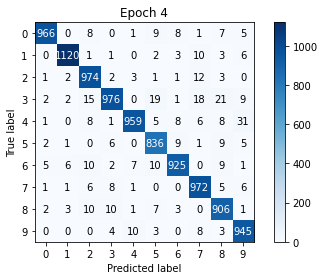

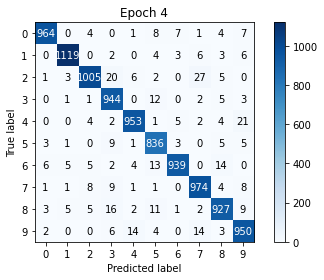

In [12]:
# expt_id = mlflow.create_experiment('Fixed nH')
# lr (, 0.02, 0.05, 0.1)
# momemtum (, 0.95, 0.99)

mlflow.set_experiment('Fixed nH')

for lr in [0.01]:
    for momentum in [0.95]:
        for hidden_nodes in [32, 48]:
        
            expt_id = '%d_%d_%d' % (int(lr*100), int(momentum*100), hidden_nodes)

            print('\nLR = %.2f, Momentum = %.2f, Hidden nodes = %d\n' % (lr, momentum, hidden_nodes))

            model = Model(hidden_nodes)

            loss_fn = nn.CrossEntropyLoss()
            opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum)

            with mlflow.start_run() as run:  
                for key, value in vars(args).items():
                    mlflow.log_param(key, value)
                mlflow.log_param('lr', lr)
                mlflow.log_param('momentum', momentum)
                mlflow.log_param('hidden_nodes', hidden_nodes)

                for epoch in range(1, args.epochs + 1):
                    train(epoch)
                    test(epoch)

                mlflow.pytorch.log_model(model, 'models')

##Loading And VIsualizing model

In [16]:
model_load = mlflow.pytorch.load_model('/content/mlruns/1/48112033a6b54c65b761939ffe2bdc92/artifacts/models')

In [17]:
print(model_load)

Model(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=48, bias=True)
    (1): ReLU()
    (2): Linear(in_features=48, out_features=10, bias=True)
  )
)


In [19]:
weight_layer0 = list(model_load.parameters())[0].data.numpy()

In [20]:
print(weight_layer0.shape)

(48, 784)


[]

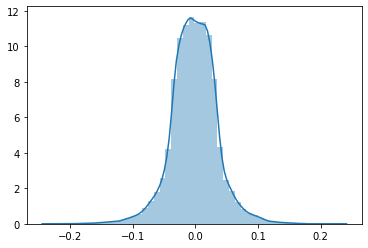

In [21]:
sns.distplot(weight_layer0.ravel())
plt.plot()

[]

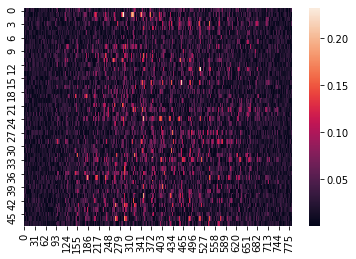

In [22]:
sns.heatmap(np.abs(weight_layer0))
plt.plot()

In [23]:
weight_layer1 = list(model_load.parameters())[2].data.numpy()
print(weight_layer1.shape)

(10, 48)


[]

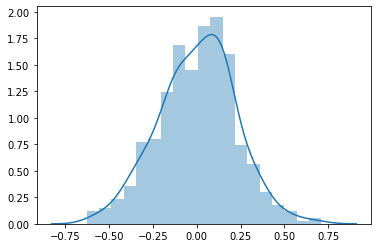

In [24]:
sns.distplot(weight_layer1.ravel())
plt.plot()

[]

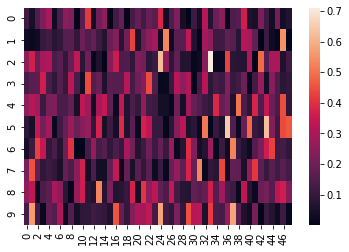

In [25]:
sns.heatmap(np.abs(weight_layer1))
plt.plot()

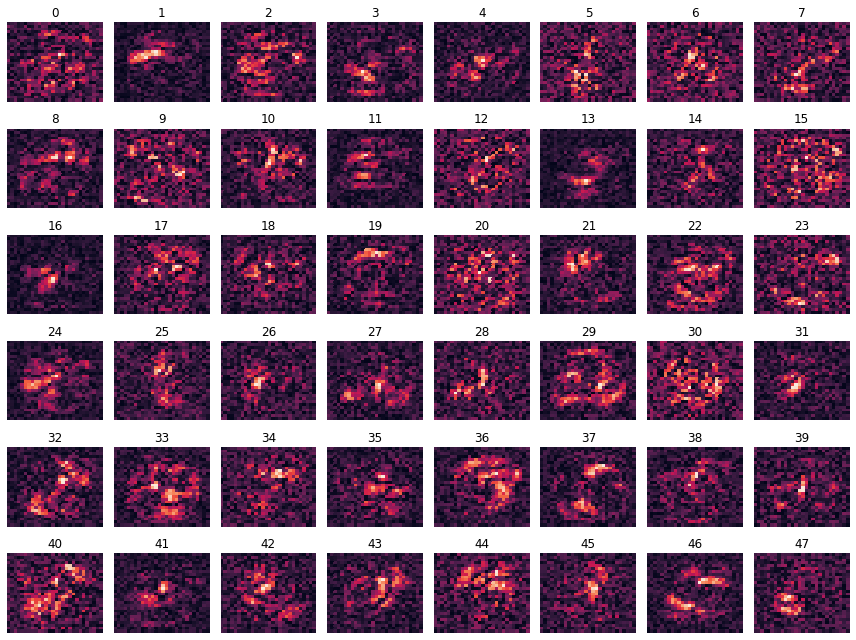

In [26]:
nrows = 6
ncols = 8
fig = plt.figure(figsize=(1.5*ncols, 1.5*nrows))

for i in np.arange(48): 
    ax1 = fig.add_subplot(nrows, ncols, i+1)
    sns.heatmap(np.abs((weight_layer0[i, 0:784]).reshape(28, 28)), ax = ax1, cbar=False)
    ax1.axis('off')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_title(i)
plt.tight_layout()
plt.show()